In [ ]:
# !pip install -e git+https://github.com/maho3/ltu-ili#egg=ltu-ili
# !pip install "ltu-ili[pytorch]"
# !black drive/MyDrive/classes/STCS6701/final_project/final.ipynb
# !pip install tarp

ili is a package based on (sbi, pydelfi, and lampe) : https://github.com/maho3/ltu-ili/tree/main

In [ ]:
import torch
import torch.nn as nn
import pickle
import ili
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import tqdm
import tarp

plt.rcParams.update(
    {
        "text.usetex": False,
        # "font.family": "Helvetica",
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "font.size": 11,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "ytick.right": True,
        "xtick.top": True,
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "xtick.minor.size": 2,
        "ytick.minor.size": 2,
    }
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


this was ran in google collab for GPU resources

In [3]:
# from google.colab import drive
# drive.mount("/content/drive")
# !ls

In [4]:
# !cd drive/MyDrive/classes/STCS6701/final_project

In [5]:
# !curl https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/IllustrisTNG/Maps_T_IllustrisTNG_LH_z=0.00.npy -o ./data/Maps_T_IllustrisTNG_LH_z=0.00.npy
# !curl https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/IllustrisTNG/Maps_Mgas_IllustrisTNG_LH_z=0.00.npy -o ./data/Maps_Mgas_IllustrisTNG_LH_z=0.00.npy

dowload the corresponding variables that generated the data above

In [6]:
# !curl https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/IllustrisTNG/params_LH_IllustrisTNG.txt -o ./data/params_LH_IllustrisTNG.txt

now load the data and param pairs

In [7]:
# log scale  for more information
# temp_data_path = "drive/MyDrive/classes/STCS6701/final_project/data/Maps_T_IllustrisTNG_LH_z=0.00.npy"
# gas_mass_data_path = "drive/MyDrive/classes/STCS6701/final_project/data/Maps_Mgas_IllustrisTNG_LH_z=0.00.npy"
# params_data_path = (
#     "drive/MyDrive/classes/STCS6701/final_project/data/params_LH_IllustrisTNG.txt"
# )

temp_data_path = "/mnt/ceph/users/camels/PUBLIC_RELEASE/CMD/2D_maps/data/IllustrisTNG/Maps_T_IllustrisTNG_LH_z=0.00.npy"
gas_mass_data_path = "/mnt/ceph/users/camels/PUBLIC_RELEASE/CMD/2D_maps/data/IllustrisTNG/Maps_Mgas_IllustrisTNG_LH_z=0.00.npy"
params_data_path = "/mnt/ceph/users/camels/PUBLIC_RELEASE/CMD/2D_maps/data/IllustrisTNG/params_LH_IllustrisTNG.txt"

In [8]:
x_temp = np.log10(np.load(temp_data_path))
x_gas_mass = np.log10(np.load(gas_mass_data_path))
theta = np.loadtxt(params_data_path)

In [9]:
theta = np.repeat(theta, 15, axis=0)  # recall each simulation has 15 images
theta_labels = [
    r"$\Omega_m$",
    r"$\sigma_8$",
    r"$A_{SN1}$",
    r"$A_{AGN1}$",
    r"$A_{SN2}$",
    r"$A_{AGN2}$",
]

In [10]:
print(x_temp.shape)
print(x_gas_mass.shape)
print(theta.shape)

(15000, 256, 256)
(15000, 256, 256)
(15000, 6)


break up into train (and validation) and test set

In [11]:
train_fraction = 0.9
num_total = x_temp.shape[0]

num_train = int(train_fraction * num_total)
num_test = num_total - num_train

# get random indeces for train/test split
# seed_sample = 11
# np.random.seed(seed_test)
# indices_test = np.random.permutation()

x_temp_train = x_temp[:num_train]
x_gas_mass_train = x_gas_mass[:num_train]
theta_train = theta[:num_train]

x_gas_mass_test = x_gas_mass[num_train:]
x_temp_test = x_temp[num_train:]
theta_test = theta[num_train:]

In [12]:
x_temp_train = x_temp_train[:, None, ...]
x_gas_mass_train = x_gas_mass_train[:, None, ...]

In [13]:
x_temp_test = x_temp_test[:, None, ...]
x_gas_mass_test = x_gas_mass_test[:, None, ...]

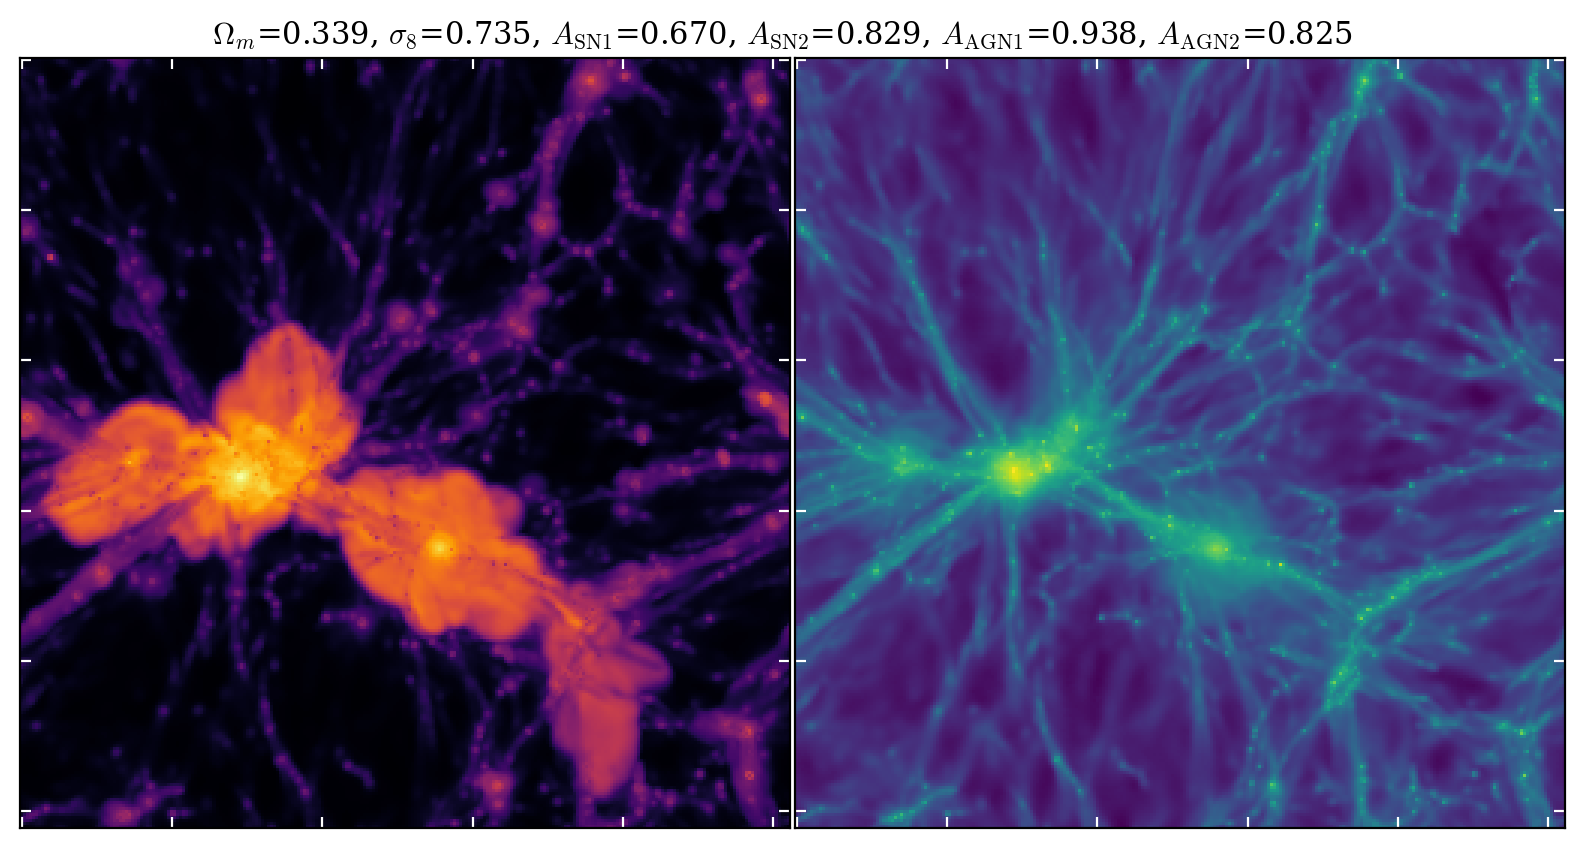

In [14]:
# visualize a random temp and density field
random = np.random.randint(0, x_temp_train.shape[0])
fig, ax = plt.subplots(1, 2, dpi=200, figsize=(10, 5))
plt.subplots_adjust(wspace=0.0, hspace=0.05)
ax[0].imshow(x_temp_train[random][0], cmap="inferno")
ax[1].imshow(x_gas_mass_train[random][0], cmap="viridis")
ax[0].text(
    0.25,
    1.05,
    r"$\Omega_m$="
    + f"{theta_train[random][0]:.3f}, "
    + r"$\sigma_8$="
    + f"{theta_train[random][1]:.3f}"
    + r", $A_{{\rm SN1}}$="
    + f"{theta_train[random][2]:.3f}"
    + r", $A_{{\rm SN2}}$="
    + f"{theta_train[random][3]:.3f}"
    + r", $A_{{\rm AGN1}}$="
    + f"{theta_train[random][4]:.3f}"
    + r", $A_{{\rm AGN2}}$="
    + f"{theta_train[random][5]:.3f}",
    ha="left",
    va="top",
    transform=ax[0].transAxes,
)
for i in range(2):
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    # set ticks to white
    ax[i].tick_params(axis="both", which="both", colors="white")
plt.savefig("./random_temp_gasmass.png", bbox_inches="tight", dpi=300, pad_inches=0.1)
plt.show()

In [15]:
# make a dataloader
temp_loader = ili.dataloaders.NumpyLoader(
    x=x_temp_train, theta=theta_train
)  # splits data into train and validation sets internally

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=8, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.Conv2d(16, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out


embedding_CNN = CNN()

In [17]:
# determine prior bounds
prior_min = theta_test.min(axis=0)
prior_max = theta_test.max(axis=0)
prior = ili.utils.Uniform(low=prior_min, high=prior_max, device=device)

### temperature map training and validation

In [18]:
# networks to be used, can combine, but let's try one by one
nets = [
    ili.utils.load_nde_sbi(
        engine="NPE",
        model="maf",
        hidden_features=50,
        num_transforms=5,
        embedding_net=embedding_CNN,
    ),
]

# define training arguments
train_args = {
    "training_batch_size": 32,
    "learning_rate": 5e-5,
    "stop_after_epochs": 50,
}

# initialize the trainer
temperature_runner = ili.inference.InferenceRunner.load(
    backend="sbi",
    engine="NPE",
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir="./temp_model_maf",
)

# load previously saved model, if not run
if os.path.exists("./temp_model_maf/posterior.pkl"):
    # load the model from the directory
    posterior_ensemble_temp = pickle.load(open("./temp_model_maf/posterior.pkl", "rb"))
    summaries_temp = json.load(open("./temp_model_maf/summary.json", "r"))
else:
    # train the model on temperature this outputs a posterior model and training logs
    print("there are no saved models, training now...")
    posterior_ensemble_temp, summaries_temp = temperature_runner(loader=temp_loader)

In [19]:
summaries_temp[0].keys()

dict_keys(['epochs_trained', 'best_validation_loss', 'validation_loss', 'training_loss', 'epoch_durations_sec', 'training_log_probs', 'validation_log_probs', 'best_validation_log_prob'])

In [20]:
N_samples = 500
seed_test = 144
np.random.seed(seed_test)

# index of the chosen input to condition on for single value diagnostics
index_of_single_sample = np.random.randint(len(theta_test))
random_test = torch.Tensor(x_temp_test[index_of_single_sample]).to(device)

In [21]:
random_test.shape

torch.Size([1, 256, 256])

### here we test sampling from the posterior conditioned on the chosen input for gas temperature

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

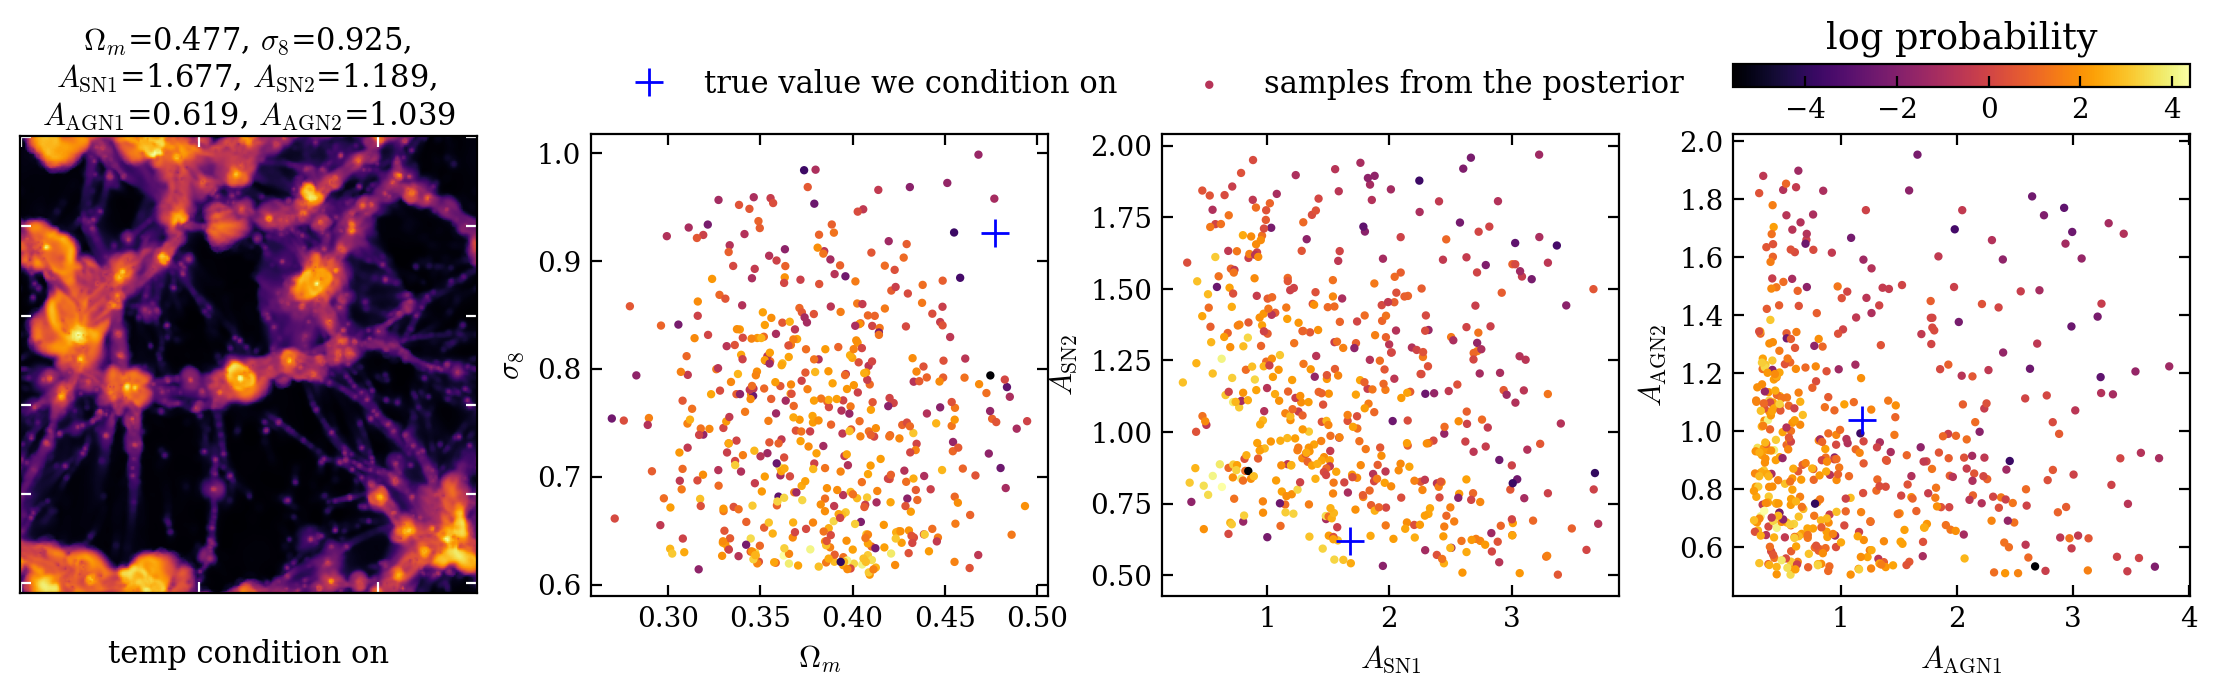

In [22]:
seed_sample = 777
torch.manual_seed(seed_sample)
# sample conditioned on the chosen input
samples_temp = posterior_ensemble_temp.sample((N_samples,), random_test)
# calculate the log_prob for each sample
log_prob_temp = posterior_ensemble_temp.log_prob(samples_temp, random_test)

samples = samples_temp.cpu().numpy()
log_prob = log_prob_temp.cpu().numpy()

# plot the posterior samples and the true value
labels = [
    r"$\Omega_m$",
    r"$\sigma_8$",
    r"$A_{\rm SN1}$",
    r"$A_{\rm AGN1}$",
    r"$A_{\rm SN2}$",
    r"$A_{\rm AGN2}$",
]
fig, ax = plt.subplots(1, 4, figsize=(14, 3), dpi=200)
plt.subplots_adjust(wspace=0.25)


ax[1].plot(
    theta[index_of_single_sample, 0],
    theta[index_of_single_sample, 1],
    "b+",
    markersize=10,
    label="true value we condition on",
)
im = ax[1].scatter(
    samples[:, 0],
    samples[:, 1],
    c=log_prob,
    s=4,
    label="samples from the posterior",
    vmin=log_prob.min(),
    vmax=log_prob.max(),
    cmap="inferno",
)
ax[1].set_xlabel(labels[0])
ax[1].set_ylabel(labels[1])
# ASN1 vs ASN2
ax[2].plot(
    theta[index_of_single_sample, 2],
    theta[index_of_single_sample, 4],
    "b+",
    markersize=10,
    label="true",
)
ax[2].scatter(
    samples[:, 2],
    samples[:, 4],
    c=log_prob,
    s=4,
    label="samples from the posterior",
    cmap="inferno",
)
ax[2].set_xlabel(labels[2])
ax[2].set_ylabel(labels[4])

# AGN1 vs AGN2
ax[3].plot(
    theta[index_of_single_sample, 3],
    theta[index_of_single_sample, 5],
    "b+",
    markersize=10,
    label="true value we condition on",
)
ax[3].scatter(
    samples[:, 3],
    samples[:, 5],
    c=log_prob,
    s=4,
    label="samples from the posterior",
    cmap="inferno",
)
ax[3].set_xlabel(labels[3])
ax[3].set_ylabel(labels[5])

cbar_axins = ax[3].inset_axes([0, 1.1, 1, 0.05])
cbar = fig.colorbar(im, cax=cbar_axins, orientation="horizontal")
cbar_axins.set_title("log probability")

# draw the image on the first axis, and label with true parameters
ax[0].imshow(
    x_temp_test[index_of_single_sample][0], cmap="inferno"
)  # same from the test set
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
# set ticks to white
ax[0].tick_params(axis="both", which="both", colors="white")
ax[0].text(
    0.5,
    1.01,
    r"$\Omega_m$="
    + f"{theta[index_of_single_sample][0]:.3f}, "
    + r"$\sigma_8$="
    + f"{theta[index_of_single_sample][1]:.3f}, \n"
    + r"$A_{{\rm SN1}}$="
    + f"{theta[index_of_single_sample][2]:.3f}"
    + r", $A_{{\rm SN2}}$="
    + f"{theta[index_of_single_sample][3]:.3f}, \n"
    + r"$A_{{\rm AGN1}}$="
    + f"{theta[index_of_single_sample][4]:.3f}"
    + r", $A_{{\rm AGN2}}$="
    + f"{theta[index_of_single_sample][5]:.3f}",
    ha="center",
    va="bottom",
    transform=ax[0].transAxes,
)

ax[0].text(
    0.5, -0.1, "temp condition on", ha="center", va="top", transform=ax[0].transAxes
)

ax[1].legend(frameon=False, loc="upper left", bbox_to_anchor=(0, 1.2), ncols=2)
# plt.colorbar(im, label="log probability", use_gridspec=True, cax=ax[2])
plt.savefig(
    "./maf_posterior_sample_temp.png", bbox_inches="tight", dpi=300, pad_inches=0.1
)

we can plot the sampled values on the y and the true thetas on the x

In [92]:
Nsamps = 10  # number of posterior samples per test point

test_set = x_temp_test
Nparams = theta.shape[1]  # number of parameters to guess

len_test_set = test_set.shape[0]
posterior_samples_temp = np.zeros((Nsamps, len_test_set, Nparams))

for ii in tqdm.tqdm(range(len_test_set)):
    # ensure x is a torch tensor on the same device as the posterior
    x_obs = torch.tensor(test_set[ii]).to(device)
    samples_t = posterior_ensemble_temp.sample(
        (Nsamps,), x_obs, show_progress_bars=False
    )
    posterior_samples_temp[:, ii] = samples_t.cpu().numpy()

sample_means_temp = np.mean(posterior_samples_temp, axis=0)
sample_stds_temp = np.std(posterior_samples_temp, axis=0)
sample_stds_temp = np.std(posterior_samples_temp, axis=0)

100%|██████████| 1500/1500 [00:34<00:00, 43.55it/s]


In [81]:
print(len_test_set)  # 10 percent of the data

1500


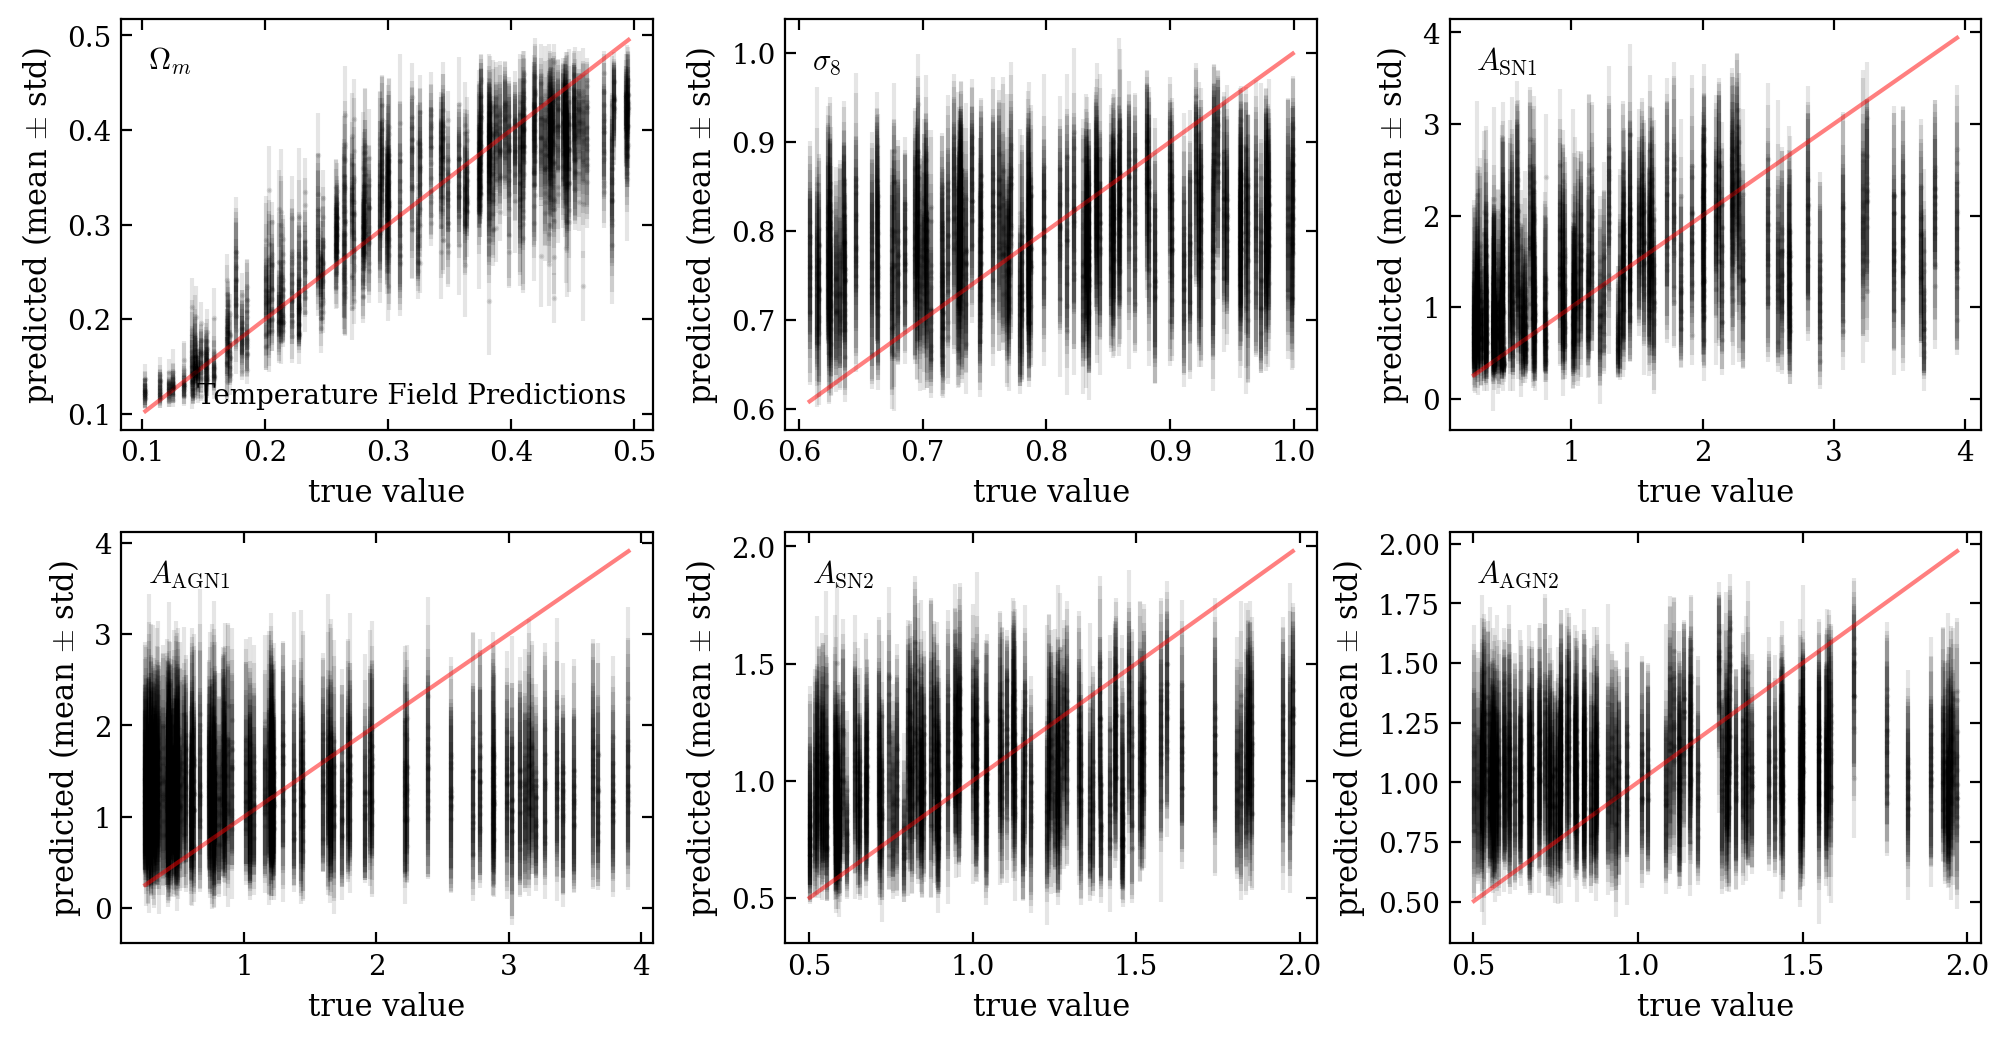

In [91]:
# we can plot the sampled values on the y and the true thetas on the x for each parameter
fig, ax = plt.subplots(2, 3, figsize=(12, 6), dpi=200)
plt.subplots_adjust(wspace=0.25, hspace=0.25)
ax = ax.flatten()
for i in range(Nparams):
    ax[i].errorbar(
        theta_test[:, i],
        sample_means_temp[:, i],
        yerr=sample_stds_temp[:, i],
        fmt="o",
        markersize=1,
        color="k",
        alpha=0.1,
    )
    ax[i].set_xlabel("true value")
    ax[i].set_ylabel(r"predicted (mean $\pm$ std)")
    ax[i].text(
        0.05,
        0.9,
        labels[i],
        ha="left",
        va="center",
        transform=ax[i].transAxes,
    )
    # add 1:1 line
    ax[i].plot(
        [prior_min[i], prior_max[i]],
        [prior_min[i], prior_max[i]],
        "r-",
        alpha=0.5,
    )
ax[0].text(
    0.95,
    0.05,
    "Temperature Field Predictions",
    ha="right",
    va="bottom",
    transform=ax[0].transAxes,
    fontsize=10,
)
plt.savefig(
    f"./maf_predictions_temp.png",
    bbox_inches="tight",
    dpi=200,
    pad_inches=0.1,
)
plt.show()

## now for learning parametes using gas mass maps

In [26]:
gas_mass_loader = ili.dataloaders.NumpyLoader(x=x_gas_mass_train, theta=theta_train)

# networks to be used, can combine, but let's try one by one
nets = [
    ili.utils.load_nde_sbi(
        engine="NPE",
        model="maf",
        hidden_features=50,
        num_transforms=5,
        embedding_net=embedding_CNN,
    ),
]

# define training arguments
train_args = {
    "training_batch_size": 32,
    "learning_rate": 5e-5,
    "stop_after_epochs": 50,
}

# initialize the trainer
gas_mass_runner = ili.inference.InferenceRunner.load(
    backend="sbi",
    engine="NPE",
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir="./gas_mass_model_maf",
)

# load previously saved model, if not run
if os.path.exists("./gas_mass_model_maf/posterior.pkl"):
    # load the model from the directory
    posterior_ensemble_gas_mass = pickle.load(
        open("./gas_mass_model_maf/posterior.pkl", "rb")
    )
    summaries_gas_mass = json.load(open("./gas_mass_model_maf/summary.json", "r"))
else:
    # train the model on temperature this outputs a posterior model and training logs
    print("there are no saved models, training now...")
    posterior_ensemble_gas_mass, summaries_gas_mass = gas_mass_runner(
        loader=gas_mass_loader
    )

100%|██████████| 1500/1500 [00:35<00:00, 42.41it/s]


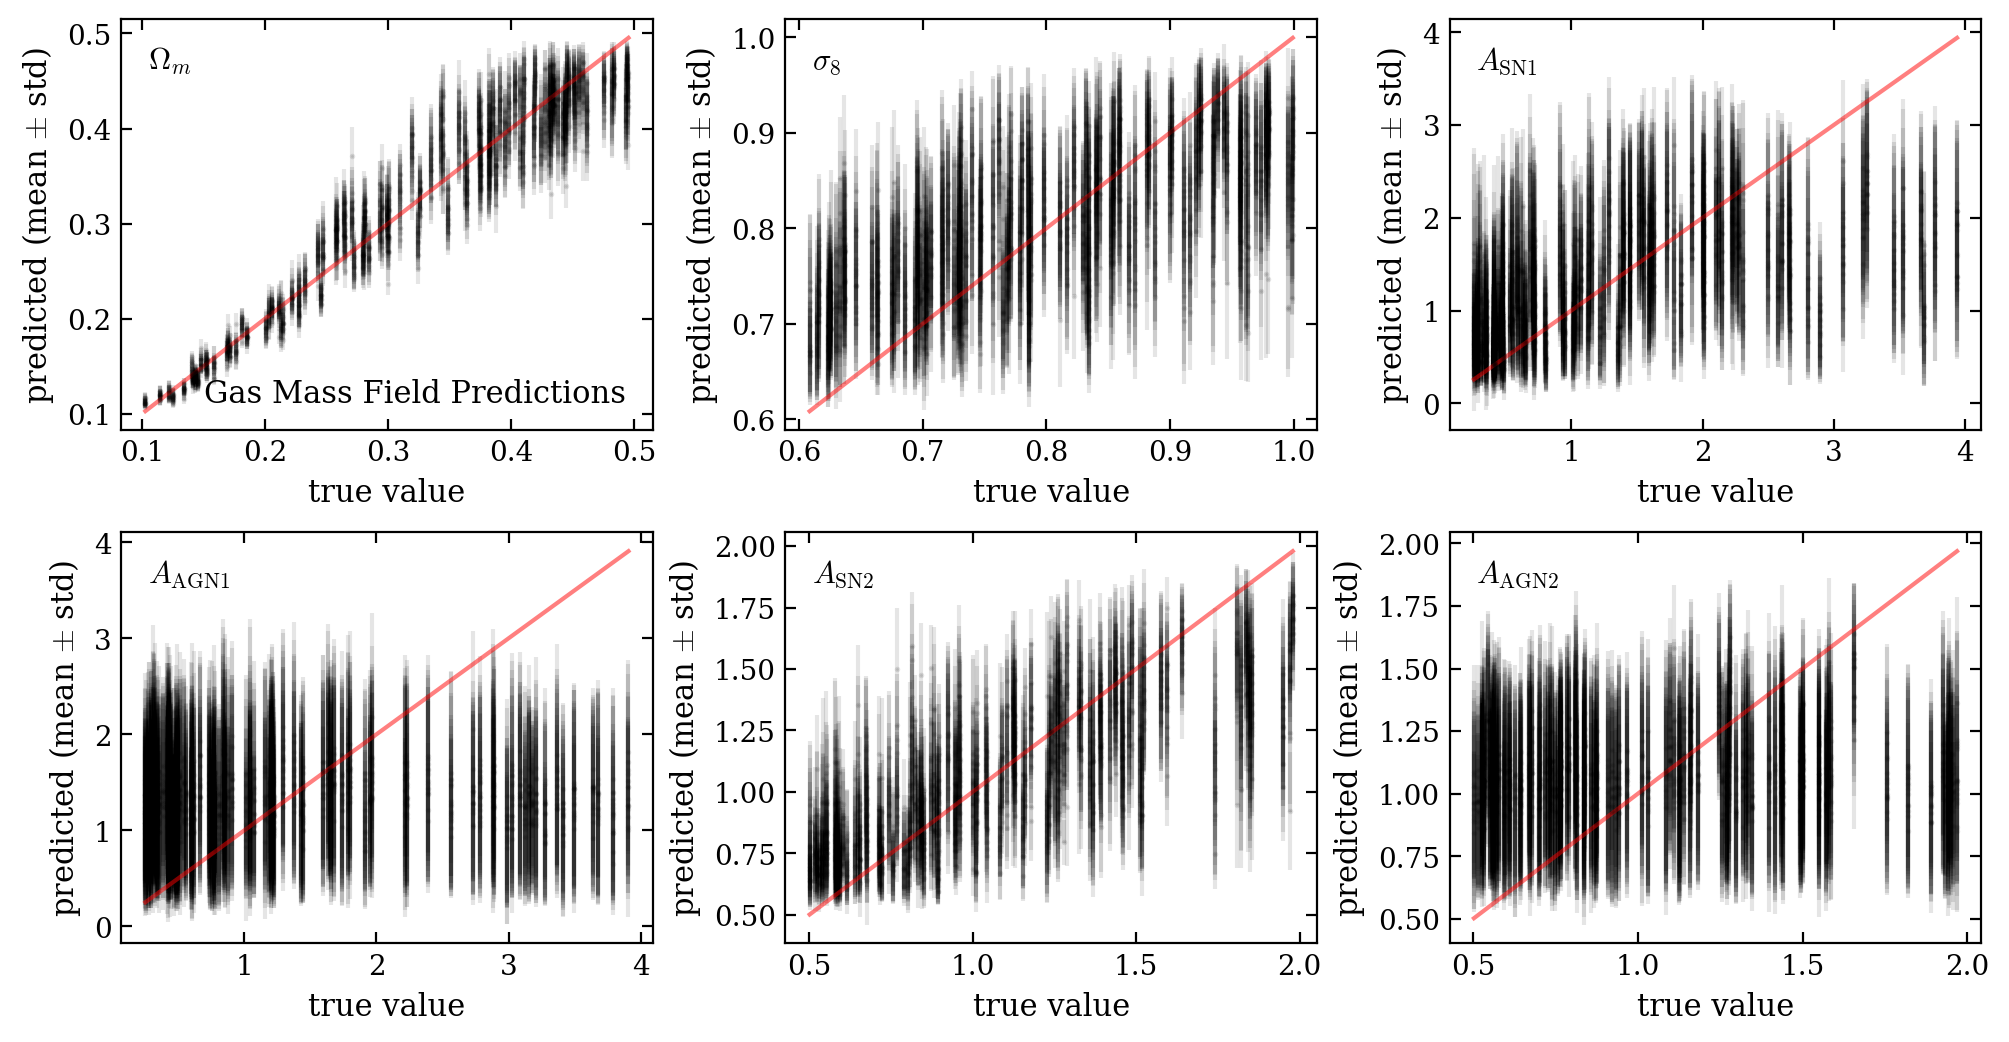

In [86]:
Nsamps = 25  # number of posterior samples per test point

test_set = x_gas_mass_test
Nparams = theta.shape[1]  # number of parameters to guess

len_test_set = test_set.shape[0]
posterior_samples_gas_mass = np.zeros((Nsamps, len_test_set, Nparams))

for ii in tqdm.tqdm(range(len_test_set)):
    # ensure x is a torch tensor on the same device as the posterior
    x_obs = torch.tensor(test_set[ii]).to(device)
    samples_t = posterior_ensemble_gas_mass.sample(
        (Nsamps,), x_obs, show_progress_bars=False
    )
    posterior_samples_gas_mass[:, ii] = samples_t.cpu().numpy()

sample_means_gas_mass = np.mean(posterior_samples_gas_mass, axis=0)
sample_stds_gas_mass = np.std(posterior_samples_gas_mass, axis=0)
sample_stds_gas_mass = np.std(posterior_samples_gas_mass, axis=0)
# we can plot the sampled values on the y and the true thetas on the x for each parameter
fig, ax = plt.subplots(2, 3, figsize=(12, 6), dpi=200)
plt.subplots_adjust(wspace=0.25, hspace=0.25)
ax = ax.flatten()
for i in range(Nparams):
    ax[i].errorbar(
        theta_test[:, i],
        sample_means_gas_mass[:, i],
        yerr=sample_stds_gas_mass[:, i],
        fmt="o",
        markersize=1,
        color="k",
        alpha=0.1,
    )
    ax[i].set_xlabel("true value")
    ax[i].set_ylabel(r"predicted (mean $\pm$ std)")
    ax[i].text(
        0.05,
        0.9,
        labels[i],
        ha="left",
        va="center",
        transform=ax[i].transAxes,
    )
    # add 1:1 line
    ax[i].plot(
        [prior_min[i], prior_max[i]],
        [prior_min[i], prior_max[i]],
        "r-",
        alpha=0.5,
    )
ax[0].text(
    0.95,
    0.05,
    "Gas Mass Field Predictions",
    ha="right",
    va="bottom",
    transform=ax[0].transAxes,
    fontsize=11,
)
plt.savefig(
    f"./maf_predictions_gas_mass.png",
    bbox_inches="tight",
    dpi=200,
    pad_inches=0.1,
)
plt.show()

### try MDN instead of MAF

In [ ]:
nets_mdn = [
    ili.utils.load_nde_sbi(
        engine="NPE",
        model="mdn",
        hidden_features=50,
        num_components=6,
        embedding_net=embedding_CNN,
    ),
]

# define training arguments
train_args = {
    "training_batch_size": 32,
    "learning_rate": 5e-5,
    "stop_after_epochs": 50,
}

gas_mass_runner = ili.inference.InferenceRunner.load(
    backend="sbi",
    engine="NPE",
    prior=prior,
    nets=nets_mdn,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir="./gas_mass_model_mdn",
)

if os.path.exists("./gas_mass_model_mdn/posterior.pkl"):
    posterior_gas_mass_mdn = pickle.load(
        open("./gas_mass_model_mdn/posterior.pkl", "rb")
    )
    summaries_gas_mass_mdn = json.load(open("./gas_mass_model_mdn/summary.json", "r"))
else:
    print("there are no saved models, training now...")
    posterior_gas_mass_mdn, summaries_gas_mass_mdn = gas_mass_runner(
        loader=gas_mass_loader
    )

# do the same with temperature now
temperature_runner = ili.inference.InferenceRunner.load(
    backend="sbi",
    engine="NPE",
    prior=prior,
    nets=nets_mdn,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir="./temp_model_mdn",
)
if os.path.exists("./temp_model_mdn/posterior.pkl"):
    posterior_temp_mdn = pickle.load(open("./temp_model_mdn/posterior.pkl", "rb"))
    summaries_temp_mdn = json.load(open("./temp_model_mdn/summary.json", "r"))
else:
    print("there are no saved models, training now...")
    posterior_temp_mdn, summaries_temp_mdn = temperature_runner(loader=temp_loader)

### plot losses and other validation for gas and temp models

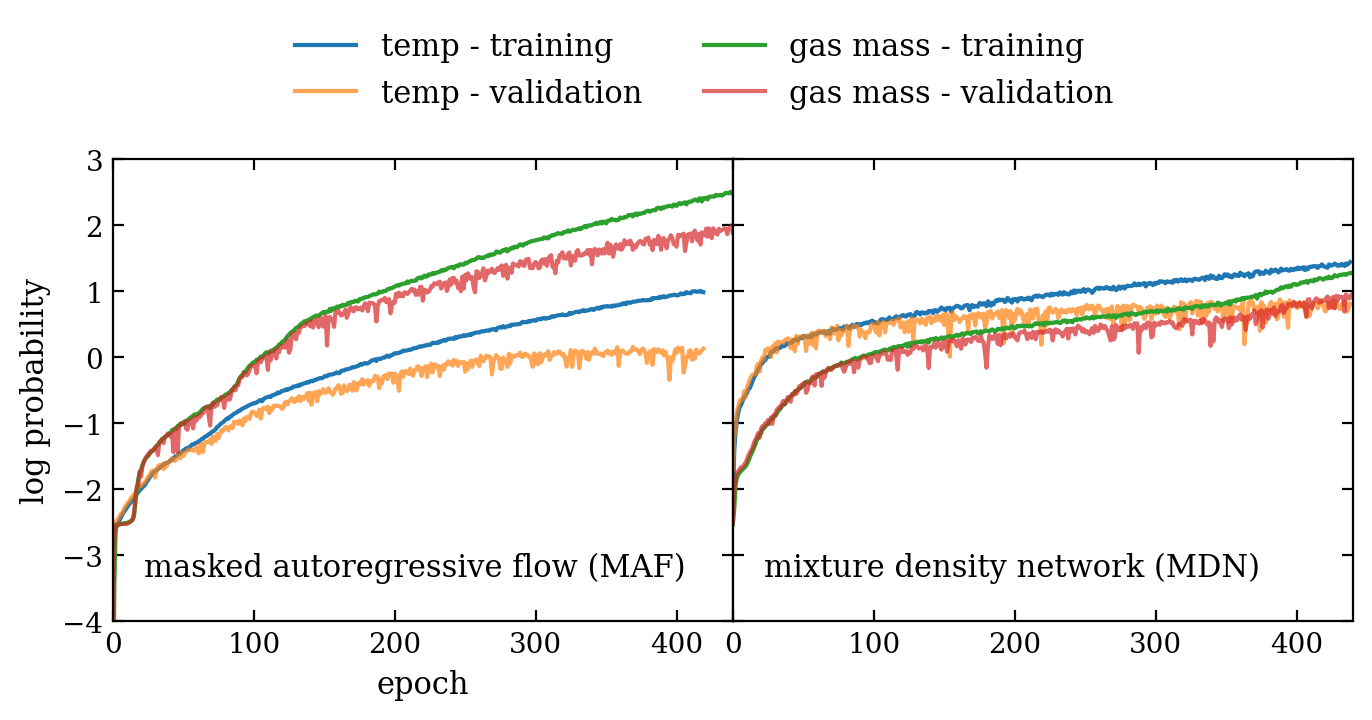

In [ ]:
# plot train/validation loss
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=200, sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.0)

for i, m in enumerate(summaries_temp):
    ax[0].plot(m["training_log_probs"], ls="-", label=f"temp - training ")
    ax[0].plot(m["validation_log_probs"], ls="-", label=f"temp - validation", alpha=0.7)

ax[0].set_xlabel("epoch")
ax[0].set_ylabel("log probability")
ax[0].set_xlim(0, None)
ax[0].set_ylim(-4, 3)


for i, m in enumerate(summaries_gas_mass):
    ax[0].plot(m["training_log_probs"], ls="-", label=f"gas mass - training ")
    ax[0].plot(
        m["validation_log_probs"], ls="-", label=f"gas mass - validation", alpha=0.7
    )


# now do the MDN
for i, m in enumerate(summaries_temp_mdn):
    ax[1].plot(m["training_log_probs"], ls="-", label=f"temp - training")
    ax[1].plot(m["validation_log_probs"], ls="-", label=f"temp - validation", alpha=0.7)

for i, m in enumerate(summaries_gas_mass_mdn):
    ax[1].plot(m["training_log_probs"], ls="-", label=f"gas mass - training ")
    ax[1].plot(
        m["validation_log_probs"], ls="-", label=f"gas mass - validation", alpha=0.7
    )

ax[0].legend(loc="lower left", frameon=False, bbox_to_anchor=(0.25, 1.05), ncols=2)
# ax[1].legend(loc="lower left", frameon=False)

# set labels for MAF vs MDN
ax[0].text(
    0.05,
    0.15,
    "masked autoregressive flow (MAF)",
    ha="left",
    va="top",
    transform=ax[0].transAxes,
)
ax[1].text(
    0.05,
    0.15,
    "mixture density network (MDN)",
    ha="left",
    va="top",
    transform=ax[1].transAxes,
)
plt.savefig(
    "./mafandmdn_log_prob_temp_and_gas_mass_vs_epoch.png",
    bbox_inches="tight",
    dpi=300,
    pad_inches=0.1,
)
plt.show()

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

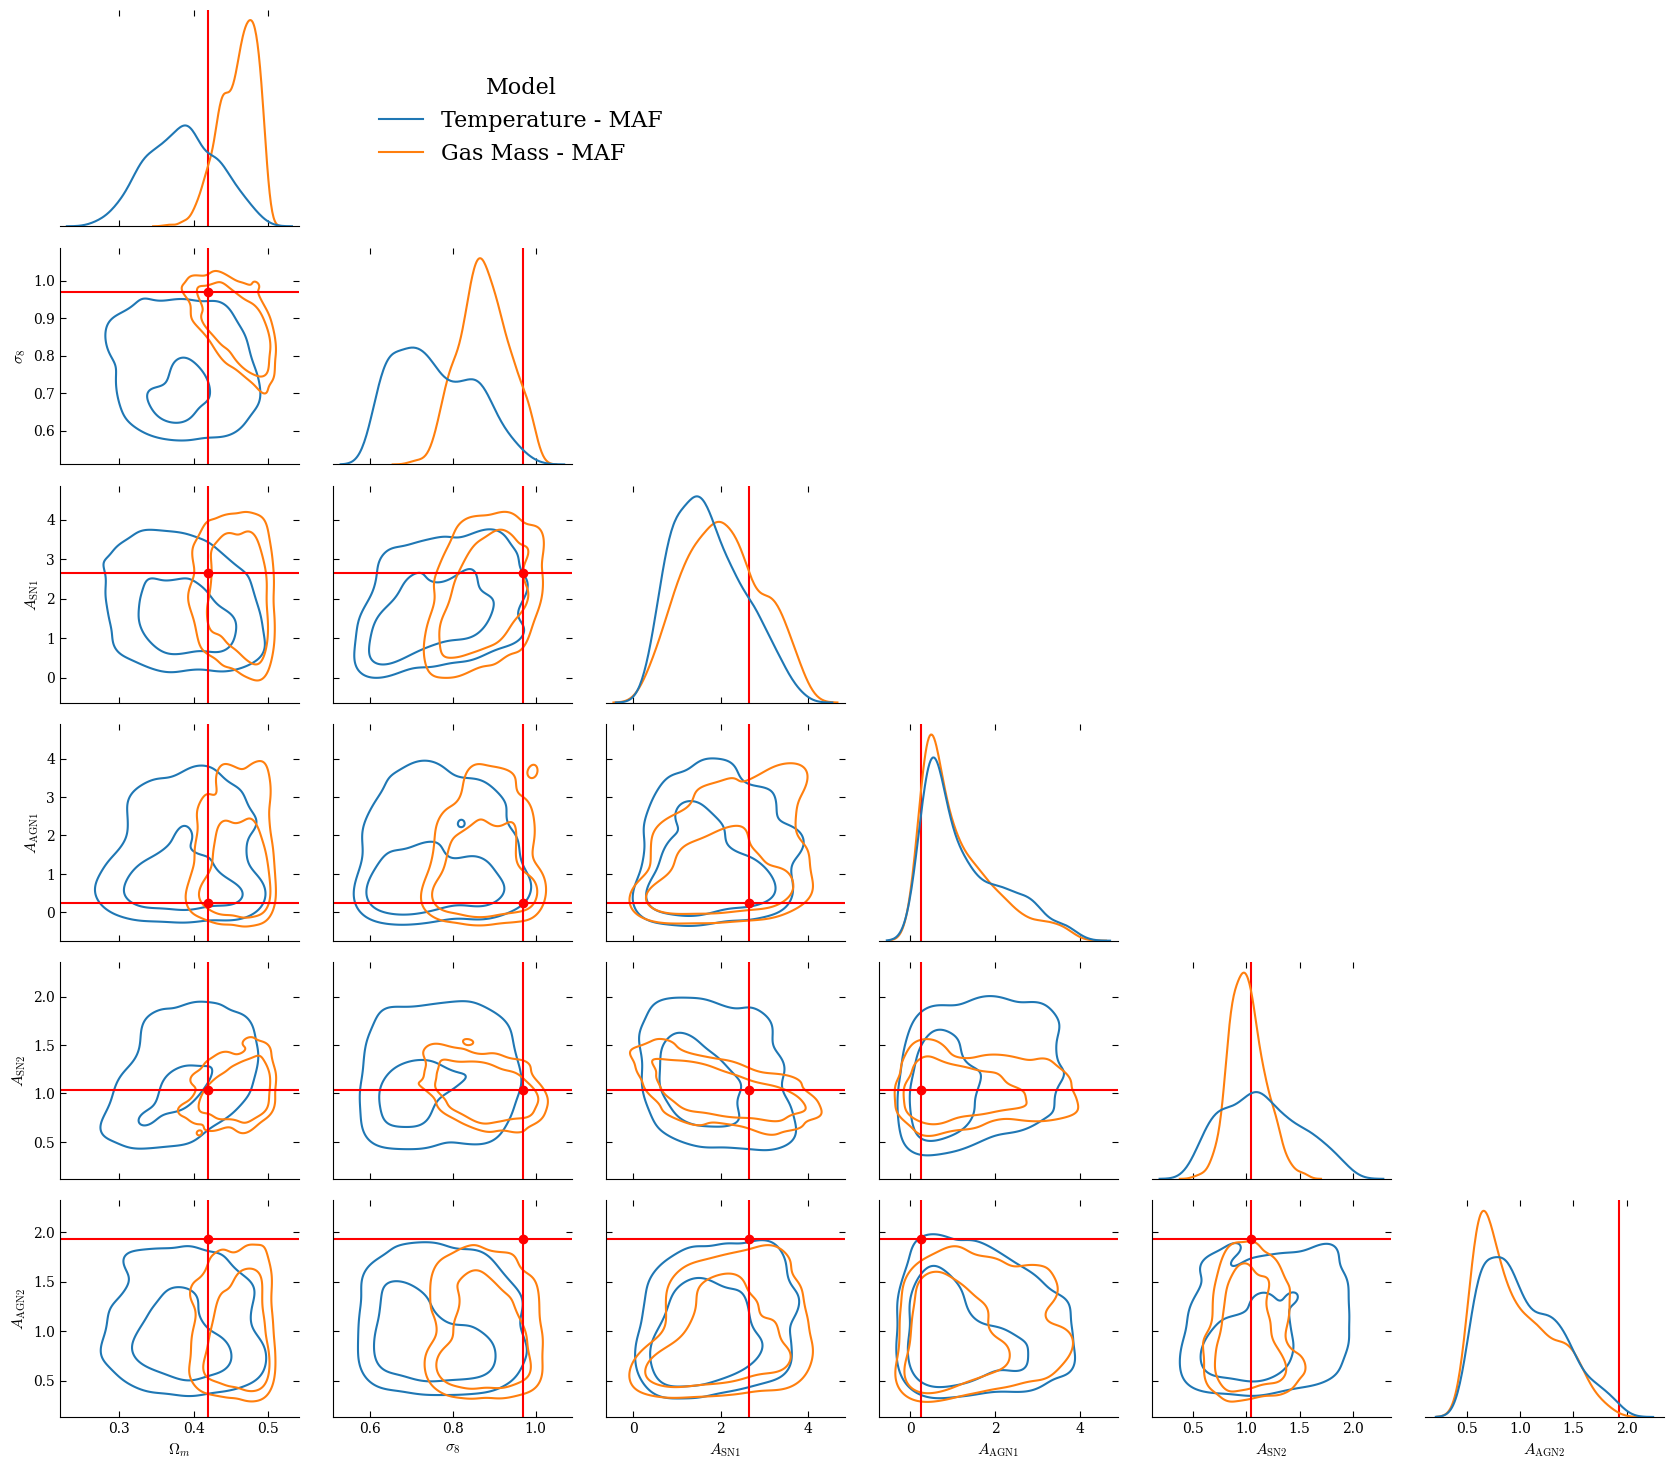

In [132]:
import seaborn as sns

metric = PlotSinglePosterior(
    num_samples=N_samples, sample_method="direct", labels=labels, out_dir=None
)
fig_maf = metric(
    posterior=posterior_ensemble_temp,
    x_obs=x_temp_test[index_of_single_sample],
    theta_fid=theta_test[index_of_single_sample],
    name="Temperature - MAF",
)
fig_maf = metric(
    posterior=posterior_ensemble_gas_mass,
    x_obs=x_gas_mass_test[index_of_single_sample],
    theta_fid=theta_test[index_of_single_sample],
    name="Gas Mass - MAF",
    grid=fig_maf,
)
# fig = metric(
#     posterior=posterior_temp_mdn,
#     x_obs=x_temp_test[index_of_single_sample],
#     theta_fid=theta_test[index_of_single_sample],
#     name="Temperature - MDN",
#     grid=fig,
# )
# fig = metric(
#     posterior=posterior_gas_mass_mdn,
#     x_obs=x_gas_mass_test[index_of_single_sample],
#     theta_fid=theta_test[index_of_single_sample],
#     name="Gas Mass - MDN",
#     grid=fig,
# )
sns.move_legend(
    fig_maf, "upper left", bbox_to_anchor=(0.2, 0.95), fontsize=16, title_fontsize=16
)
plt.savefig(
    "./maf_mdn_single_posteriors_temp_and_gas_mass.png",
    bbox_inches="tight",
    dpi=300,
    pad_inches=0.1,
    transparent=True,
)
plt.show()

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

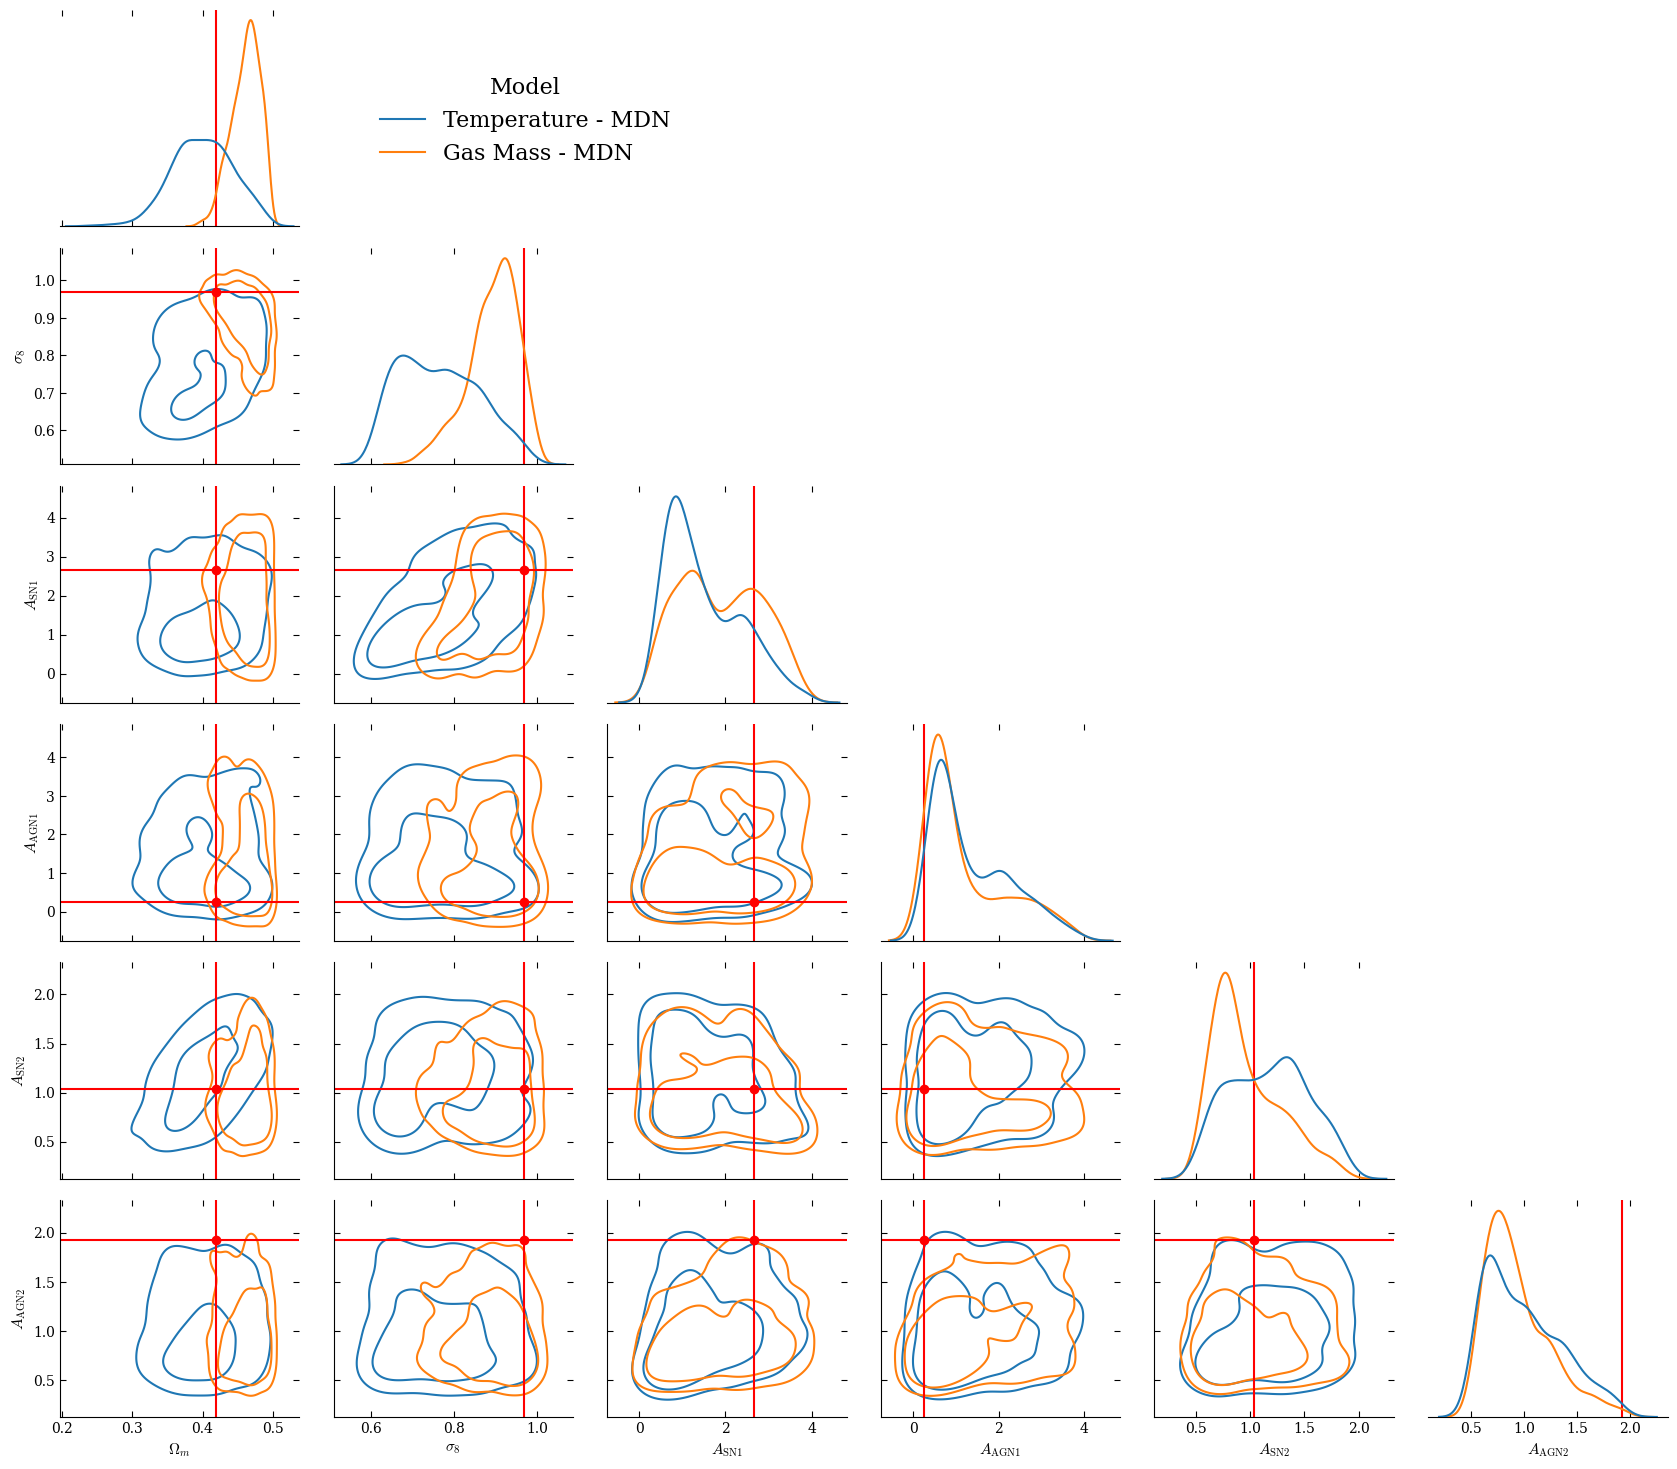

In [ ]:
metric = PlotSinglePosterior(
    num_samples=N_samples, sample_method="direct", labels=labels, out_dir=None
)

fig_mdn = metric(
    posterior=posterior_temp_mdn,
    x_obs=x_temp_test[index_of_single_sample],
    theta_fid=theta_test[index_of_single_sample],
    name="Temperature - MDN",
)
fig_mdn = metric(
    posterior=posterior_gas_mass_mdn,
    x_obs=x_gas_mass_test[index_of_single_sample],
    theta_fid=theta_test[index_of_single_sample],
    name="Gas Mass - MDN",
    grid=fig_mdn,
)
sns.move_legend(
    fig_mdn, "upper left", bbox_to_anchor=(0.2, 0.95), fontsize=16, title_fontsize=16
)
plt.savefig(
    "./mdn_single_posteriors_temp_and_gas_mass.png",
    bbox_inches="tight",
    dpi=300,
    pad_inches=0.1,
    transparent=True,
)
plt.show()

### tarp coverage tests

100%|██████████| 100/100 [00:07<00:00, 13.17it/s]


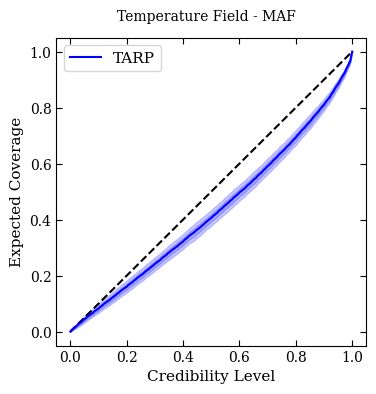

In [ ]:
# now, do tarp lotting
metric_maf = PosteriorCoverage(
    num_samples=500, sample_method="direct", labels=labels, plot_list=["tarp"]
)
fig_temp_maf = metric_maf(
    posterior=posterior_ensemble_temp,
    x=x_temp_test,
    theta=theta_test,
)
fig_temp_maf[0].text(
    0.5, 0.95, "Temperature Field - MAF", ha="center", va="top", fontsize=10
)
plt.savefig(
    "./maf_temp_TARP.png",
    bbox_inches="tight",
    dpi=300,
    pad_inches=0.1,
)

100%|██████████| 100/100 [00:07<00:00, 13.08it/s]


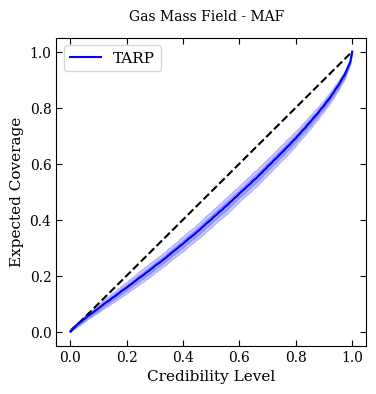

In [ ]:
fig_gas_mass_maf = metric_maf(
    posterior=posterior_ensemble_gas_mass,
    x=x_gas_mass_test,
    theta=theta_test,
)
fig_gas_mass_maf[0].text(
    0.5, 0.95, "Gas Mass Field - MAF", ha="center", va="top", fontsize=10
)
plt.savefig(
    "./maf_gas_mass_TARP.png",
    bbox_inches="tight",
    dpi=300,
    pad_inches=0.1,
)

100%|██████████| 100/100 [00:07<00:00, 13.04it/s]


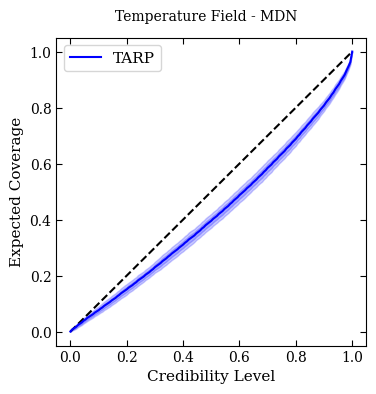

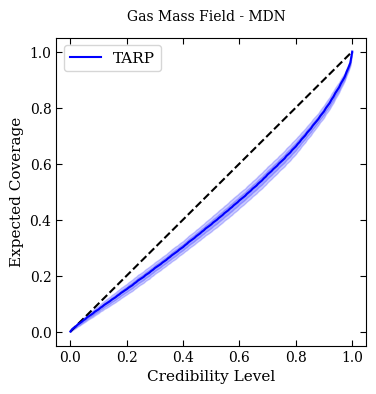

In [ ]:
# now do tarp plotting for MDN
metric_mdn = PosteriorCoverage(
    num_samples=500, sample_method="direct", labels=labels, plot_list=["tarp"]
)
fig_temp_mdn = metric_mdn(
    posterior=posterior_temp_mdn,
    x=x_temp_test,
    theta=theta_test,
)
fig_temp_mdn[0].text(
    0.5, 0.95, "Temperature Field - MDN", ha="center", va="top", fontsize=10
)
plt.savefig(
    "./mdn_temp_TARP.png",
    bbox_inches="tight",
    dpi=300,
    pad_inches=0.1,
)
fig_gas_mass_mdn = metric_mdn(
    posterior=posterior_gas_mass_mdn,
    x=x_gas_mass_test,
    theta=theta_test,
)
fig_gas_mass_mdn[0].text(
    0.5, 0.95, "Gas Mass Field - MDN", ha="center", va="top", fontsize=10
)
plt.savefig(
    "./mdn_gas_mass_TARP.png",
    bbox_inches="tight",
    dpi=300,
    pad_inches=0.1,
)

In [ ]:
# get extract the lines data for further analysis
temp_maf_lines = [line for ax in fig_temp_maf[0].axes for line in ax.get_lines()]
gas_mass_maf_lines = [
    line for ax in fig_gas_mass_maf[0].axes for line in ax.get_lines()
]
temp_mdn_lines = [line for ax in fig_temp_mdn[0].axes for line in ax.get_lines()]
gas_mass_mdn_lines = [
    line for ax in fig_gas_mass_mdn[0].axes for line in ax.get_lines()
]

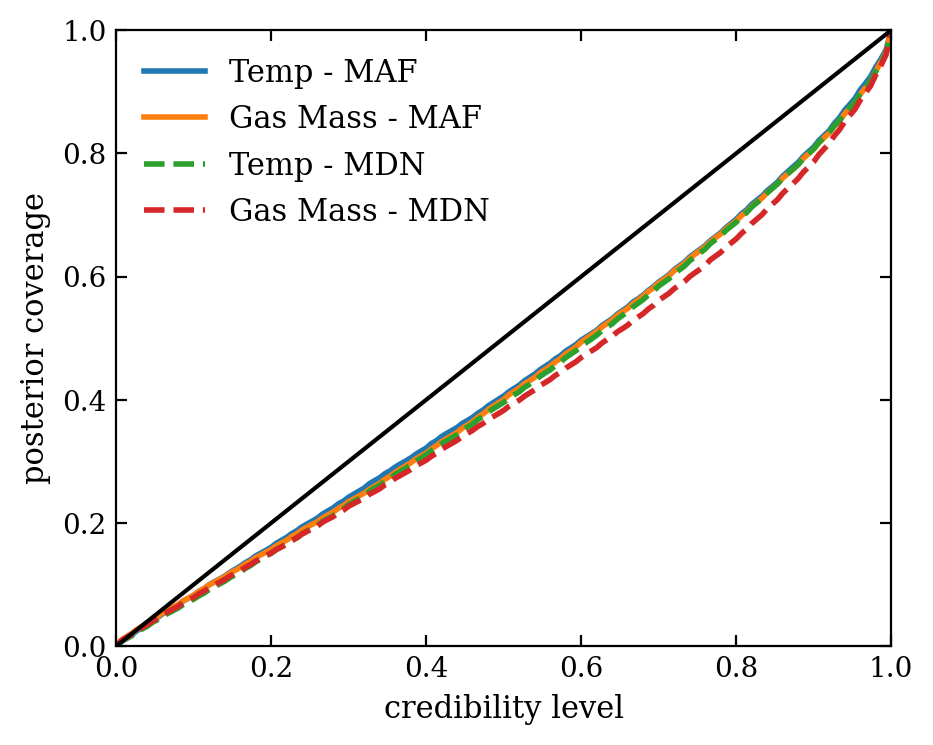

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)

ax.plot(
    temp_maf_lines[1].get_xdata(),
    temp_maf_lines[1].get_ydata(),
    label="Temp - MAF",
    alpha=1,
    lw=2
)

ax.plot(
    gas_mass_maf_lines[1].get_xdata(),
    gas_mass_maf_lines[1].get_ydata(),
    label="Gas Mass - MAF",
    alpha=1,
    lw=2
)
ax.plot(
    temp_mdn_lines[1].get_xdata(),
    temp_mdn_lines[1].get_ydata(),
    label="Temp - MDN",
    alpha=1,
    ls="--",
    lw=2
)
ax.plot(
    gas_mass_mdn_lines[1].get_xdata(),
    gas_mass_mdn_lines[1].get_ydata(),
    label="Gas Mass - MDN",
    alpha=1,
    ls="--",
    lw=2
)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.plot([0, 1], [0, 1], "k")
ax.set_xlabel("credibility level")
ax.set_ylabel("posterior coverage")
ax.legend(frameon=False)
plt.savefig(
    "./maf_mdn_temp_gas_mass_TARP_comparison.png",
    bbox_inches="tight",
    dpi=300,
    pad_inches=0.1,
)